# Élèves: Yacine KHALIL et Sami LAITA

**Importation des bibliothèques utilisées dans ce notebook:**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
Modèle déterministe SIR
</div>

Dans cette partie, on modélise l'évolution d'une épidémie au sein d'une population fixe, à l'aide d'un modèle SIR.

---

## Notations et définitions

On considère les grandeurs suivantes à chaque instant $t$ :

- $N$ : taille totale de la population (constante)
- $S(t)$ : nombre d'individus sains, qui sont susceptibles d'être infectés
- $I(t)$ : nombre d'individus actuellement infectés
- $R(t)$ : nombre d'individus retirés (guéris ou décédés), et non susceptibles de se faire réinfecter
- $s(t) = \frac{S(t)}{N}$, $i(t) = \frac{I(t)}{N}$, $r(t) = \frac{R(t)}{N}$ : proportions relatives dans chaque catégorie

Paramètres du modèle :

- $\beta > 0$ : taux de transmission par jour
- $\gamma > 0$ : taux de guérison par jour 

Le nombre de reproduction de base est défini par :

$$R_0 = \frac{\beta}{\gamma}$$

Il mesure le nombre moyen de personnes qu'un individu infecté contamine dans une population totalement saine.

---

## Système d'équations différentielles

Notre modèle est régi par le système suivant :

$$\begin{cases}
\frac{dS}{dt} = -\beta S I \\
\\
\frac{dI}{dt} = \beta S I - \gamma I \\
\\
\frac{dR}{dt} = \gamma I
\end{cases}$$


- la quantité $\beta S I$ représente les infections quotidiennes dues aux contacts entre sains et infectés.
- Variation des infectés : ils augmentent avec les nouvelles infections ($\beta S I$) et diminuent au rythme des guérisons ($\gamma I$).
- Augmentation des retirés : ceux-ci croissent au taux $\gamma I$, c'est-à-dire à la vitesse des guérisons.

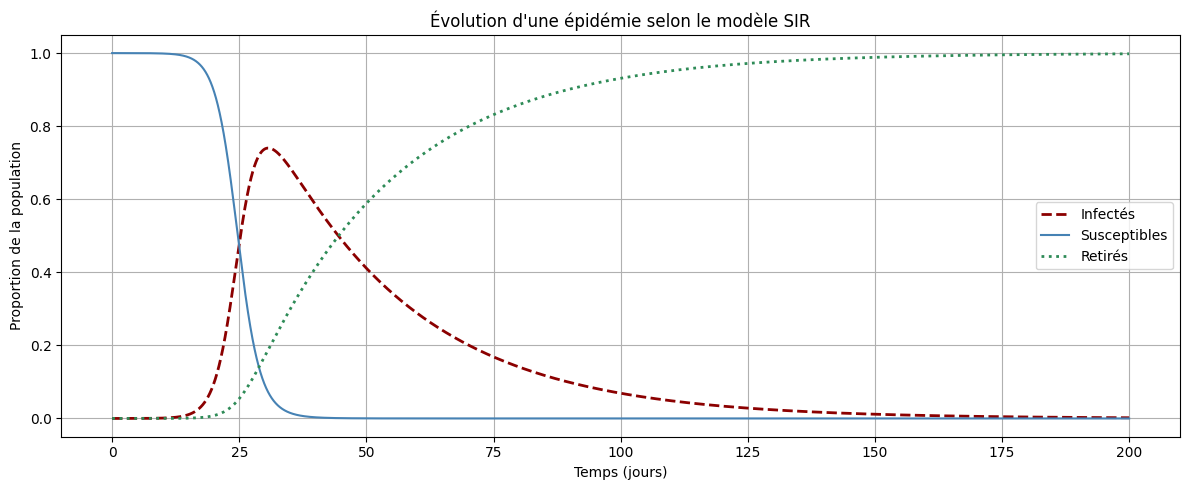

In [26]:
# Paramètres du modèle SIR

gamma = 1 / 28  # Durée moyenne d'infection : 28 jours → taux de guérison gamma
beta = 0.5  # Taux de transmission quotidien : 0.5 contaminations par individu infecté

# Conditions initiales

i_init = 1e-5  # Proportion initiale d'infectés dans la population
s_init = 1.0 - i_init  # Proportion initiale de susceptibles : reste de la population
r_init = 0.0  # Aucun retiré au départ (ni guérison ni décès)

def sir_model(t, y, gamma, beta):
    """
    Modèle SIR : système d'équations différentielles pour le modèle SIR.
    """
    i, s, r = y
    di = beta * s * i - gamma * i     # Variation des infectés
    ds = -beta * s * i      # Variation des susceptibles (contaminés)
    dr = gamma * i          # Variation des retirés (guérisons)

    return [di, ds, dr]

# Résolution numérique du système

t_start, t_end = 0, 200  # Intervalle de temps en jours

# Intégration par la méthode Runge-Kutta (ordre 5)
sol = solve_ivp(
    fun=sir_model,
    t_span=(t_start, t_end),
    y0=[i_init, s_init, r_init],
    args=(gamma, beta),
    method='RK45',
    max_step=0.01
)

# Tracé des courbes

plt.figure(figsize=(12, 5))
# Tracé des infectés
plt.plot(sol.t, sol.y[0], label="Infectés", color="darkred", linestyle='--', linewidth=2)
# Tracé des susceptibles
plt.plot(sol.t, sol.y[1], label="Susceptibles", color="steelblue", linestyle='-', linewidth=1.5)
# Tracé des retirés
plt.plot(sol.t, sol.y[2], label="Retirés", color="seagreen", linestyle=':', linewidth=2)

plt.title("Évolution d'une épidémie selon le modèle SIR")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion de la population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
Évolution du processus de Markov
</div>

Nous cherchons à simuler l'évolution de l'épidémie dans une population de N individus en utilisant un **processus de Markov à temps continu**.

Afin d’assurer la cohérence avec le modèle déterministe vu précédemment, on choisit :

$$
N = \frac{1}{i_0} - 1
$$

où $i_0$ représente la proportion initiale de personnes infectées.

---

### Hypothèses du modèle stochastique :

- On modélise $(S(t), I(t), R(t))$ comme un processus de Markov, prenant ses valeurs dans l’ensemble :
  $$
  \{ (S, I, R) \in \mathbb{N}^3 : S + I + R = N + 1 \}
  $$
- Un individu infecté :
  - transmet la maladie à un individu sain avec un taux $\beta$,
  - guérit (ou est retiré) avec un taux $\gamma$,
- Chaque individu sain peut être contaminé au rythme des rencontres infectieuses,
- La durée d’infection suit une loi exponentielle de paramètre $\gamma$,
- Les événements (infection ou guérison) se produisent selon des lois exponentielles.

---

### Simulation :

On simule l’évolution de ce processus en générant successivement des événements (infection ou guérison), jusqu’à atteindre un temps limite ou extinction de l’épidémie.


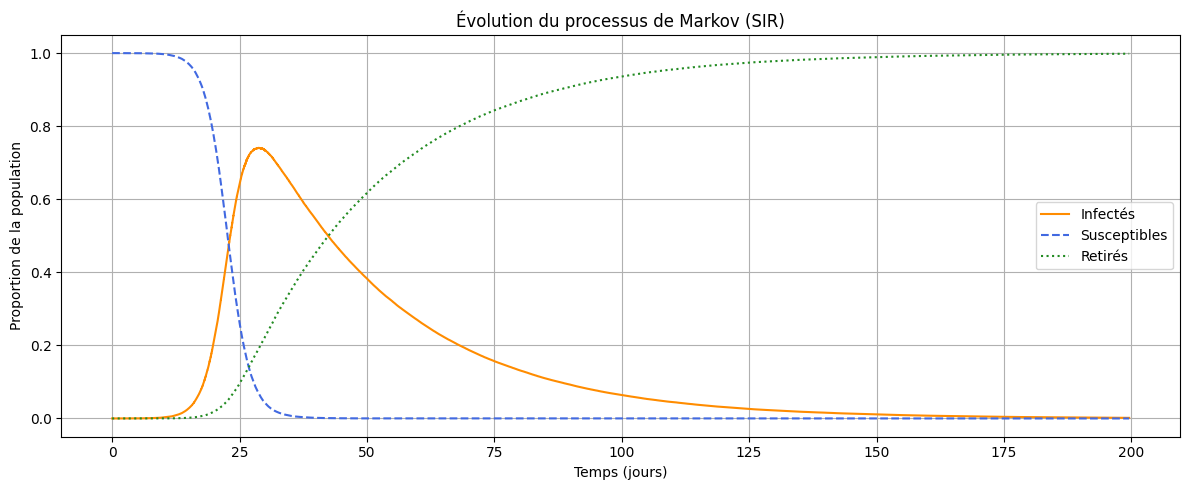

In [27]:
# Processus de Markov pour le modèle SIR

def markov(I0, S0, R0, t_max, gamma, beta):

    S_list, I_list, R_list = [S0], [I0], [R0] # Listes pour stocker les valeurs de S, I et R
    total_pop = S0 + I0 + R0    # Population totale
    S, I, R = S0, I0, R0        # État courant
    times = [0]

    # Ici on applique la méthode vue en cours pour tirer suivant une loi exponentielle
    # à partir de la loi uniforme
    U = np.random.rand()
    current_time = -np.log(U) / (I * gamma + beta * I * S / total_pop)


    # Simulation du processus jusqu'à l'extinction ou le temps maximal
    while current_time < t_max and I != 0:
        rand = np.random.rand()
        prob_recovery = I * gamma / (I * gamma + beta * I * S / total_pop + 1e-10)

        if rand < prob_recovery:
            # Guérison d'un individu
            I -= 1
            R += 1
        else:
            # Infection d'un individu sain
            S -= 1
            I += 1

        # Sauvegarde des états et du temps
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
        times.append(current_time)

        # Temps jusqu'au prochain événement
        U = np.random.rand()
        current_time += -np.log(U) / (I * gamma + beta * I * S / total_pop + 1e-10)

    return times, S_list, I_list, R_list


# Conditions initiales

i0 = 0.00001
N = int(1 / i0) - 1  # Population totale déterminée par i0

I0 = 1
S0 = N
R0 = 0

gamma = 1 / 28  # Guérison en moyenne en 28 jours
beta = 0.5      # 0.5 nouvelles infections par jour

# Exécution de la simulation

times, susceptibles, infectes, retires = markov(I0, S0, R0, 200, gamma, beta)

# Affichage des résultats

plt.figure(figsize=(12, 5))

# Courbe des infectés
plt.plot(times, np.array(infectes) / (N + 1), label="Infectés", color="darkorange", linestyle='-')
plt.plot(times, np.array(susceptibles) / (N + 1), label="Susceptibles", color="royalblue", linestyle='--')
plt.plot(times, np.array(retires) / (N + 1), label="Retirés", color="forestgreen", linestyle=':')

plt.title("Évolution du processus de Markov (SIR)")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion de la population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

On remarque que pour des mêmes paramètres d'entrée $\beta$ et $\gamma$, ainsi que pour des mêmes conditions initiales, l'évolution du processus de Markov est quasiment identique à celle du modèle SIR.

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
4. Recherche des couples de valeurs (beta, gamma)
</div>

Notre but est de trouver des couples de valeurs $(\beta,\gamma)$ où
*   Tout le monde est retiré sur le long terme (365 jours pour une année)
*   Il y a une partie de la population qui reste susceptible et une autre qui est retirée

- Couples de valeurs $(\beta, \gamma)$ pour lesquels l'intégralité de la population finit retirée à long terme dans le modèle SIR:

Le comportement asymptotique du modèle est gouverné par l'équation implicite :

$$1 - r_\infty = s_0 \cdot \exp(-R_0 \cdot r_\infty)$$

où :
- $r_\infty$ est la proportion d'individus retirés à long terme,
- $s_0$ est la proportion initiale de susceptibles,
- $R_0 = \frac{\beta}{\gamma}$ est le nombre de reproduction de base.

Si toute la population finit retirée, cela signifie que :

$$r_\infty = 1$$

On remplace dans l'équation :

$$1 - 1 = s_0 \cdot \exp(-R_0 \cdot 1) \Rightarrow 0 = s_0 \cdot \exp(-R_0)$$

Ce n'est possible que si :

$$\exp(-R_0) \to 0 \Rightarrow R_0 \to \infty$$

Donc, pour que tous les individus finissent dans l'état retiré, il faut que le rapport $\frac{\beta}{\gamma}$ soit *très grand*.  
Autrement dit, choisir une valeur de $\beta$ très supérieure à $\gamma$ est suffisant pour que l'épidémie contamine toute la population.

---


- Couples de valeurs $(\beta, \gamma)$ pour lesquels une partie de la population reste susceptible et l'autre finit retirée:

Dans ce cas, on cherche une solution $r_\infty \in (0,1)$ à l'équation :

$$1 - r_\infty = s_0 \cdot \exp(-R_0 \cdot r_\infty)$$

Cela correspond à une situation où l'épidémie se propage, mais *s'éteint avant d'avoir infecté toute la population*.

- Si $R_0 = \frac{\beta}{\gamma} < 1$, alors l'épidémie ne se propage pas : le pic d'infection n'a pas lieu.
- Si $R_0 > 1$ mais pas trop grand, alors une *proportion finie* de la population est infectée puis guérit, et une autre reste saine.

Choisir des couples $(\beta, \gamma)$ tels que :

$$1 < \frac{\beta}{\gamma} < \infty$$

permet d'obtenir une répartition finale entre les individus encore susceptibles et ceux retirés, sans que l'épidémie touche 100% de la population.

# Illustration des résultats théoriques ci-dessus par simulation:

**Cas 1:**

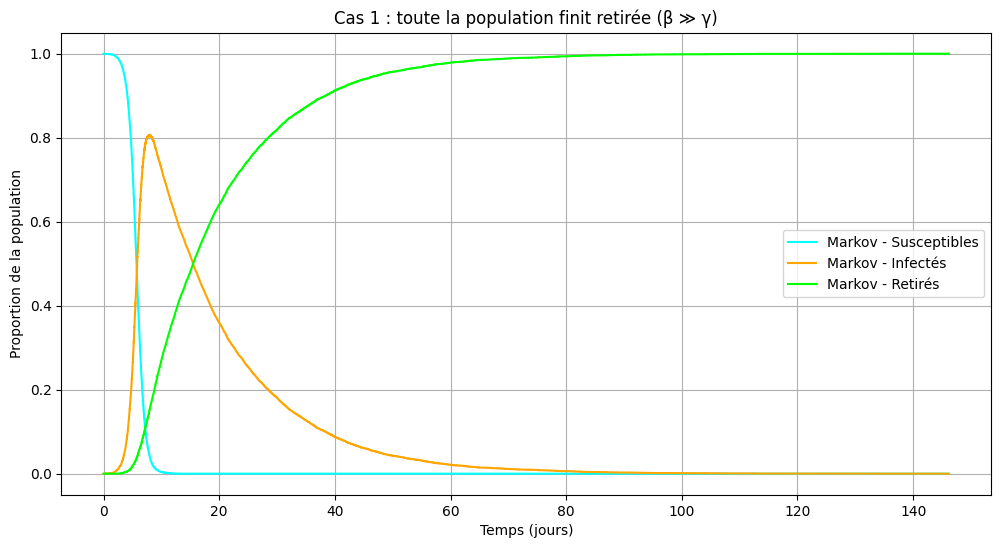

In [28]:
# CAS 1 : Toute la population finit retirée

# Paramètres
gamma = 1/14  # guérison moyenne en 14 jours
beta = 1.5    # taux d'infection élevé

# Conditions initiales
i_init = 1e-4
s_init = 1 - i_init
r_init = 0.0

# Système déterministe
sol_cas1 = solve_ivp(
    fun=sir_model,
    t_span=[0, 160],
    y0=[i_init, s_init, r_init],
    args=(gamma, beta),
    method='RK45',
    max_step=0.1
)

# Simulation Markovienne
N = int(1 / i_init) - 1
I0, S0, R0 = 1, N, 0
t_cas1, S_cas1, I_cas1, R_cas1 = markov(I0, S0, R0, 160, gamma, beta)

# Plot
plt.figure(figsize=(12,6))

plt.step(t_cas1, np.array(S_cas1)/(N+1), where='post', label="Markov - Susceptibles", color='cyan')
plt.step(t_cas1, np.array(I_cas1)/(N+1), where='post', label="Markov - Infectés", color='orange')
plt.step(t_cas1, np.array(R_cas1)/(N+1), where='post', label="Markov - Retirés", color='lime')

plt.title('Cas 1 : toute la population finit retirée (β ≫ γ)')
plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la population')
plt.grid()
plt.legend()
plt.show()

**Cas 2:**

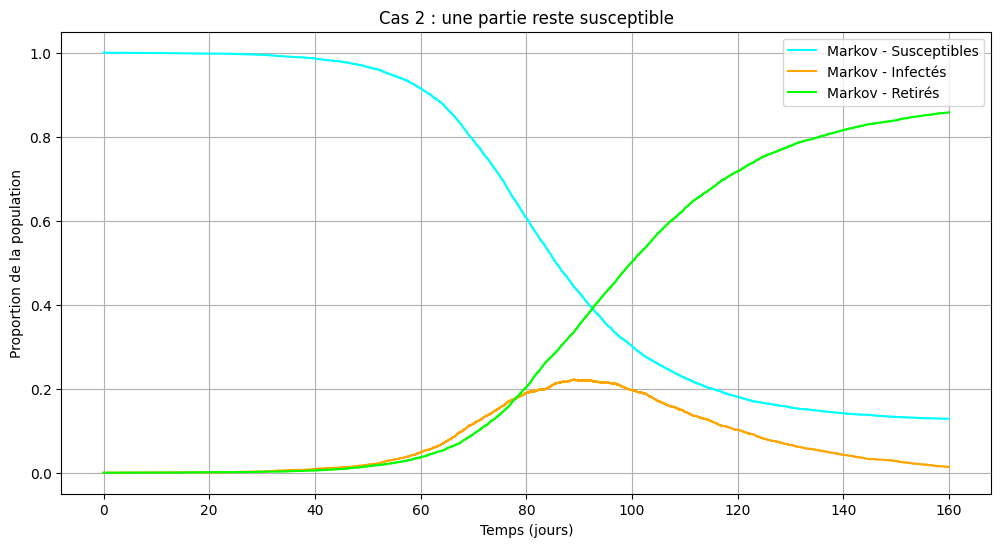

In [29]:
# CAS 2 : Une partie reste susceptible

# Paramètres
gamma = 1/14  # guérison moyenne en 14 jours
beta = 0.17   # taux d'infection modéré

# Conditions initiales
i_init = 1e-4
s_init = 1 - i_init
r_init = 0.0

# Système déterministe
sol_cas2 = solve_ivp(
    fun=sir_model,
    t_span=[0, 160],
    y0=[i_init, s_init, r_init],
    args=(gamma, beta),
    method='RK45',
    max_step=0.1
)

# Simulation Markovienne
N = int(1 / i_init) - 1
I0, S0, R0 = 1, N, 0
t_cas2, S_cas2, I_cas2, R_cas2 = markov(I0, S0, R0, 160, gamma, beta)

# Plot
plt.figure(figsize=(12,6))

# Stochastique
plt.step(t_cas2, np.array(S_cas2)/(N+1), where='post', label="Markov - Susceptibles", color='cyan')
plt.step(t_cas2, np.array(I_cas2)/(N+1), where='post', label="Markov - Infectés", color='orange')
plt.step(t_cas2, np.array(R_cas2)/(N+1), where='post', label="Markov - Retirés", color='lime')

plt.title('Cas 2 : une partie reste susceptible')
plt.xlabel('Temps (jours)')
plt.ylabel('Proportion de la population')
plt.grid()
plt.legend()
plt.show()

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
5. Illustration de la convergence du processus de Markov 
</div>

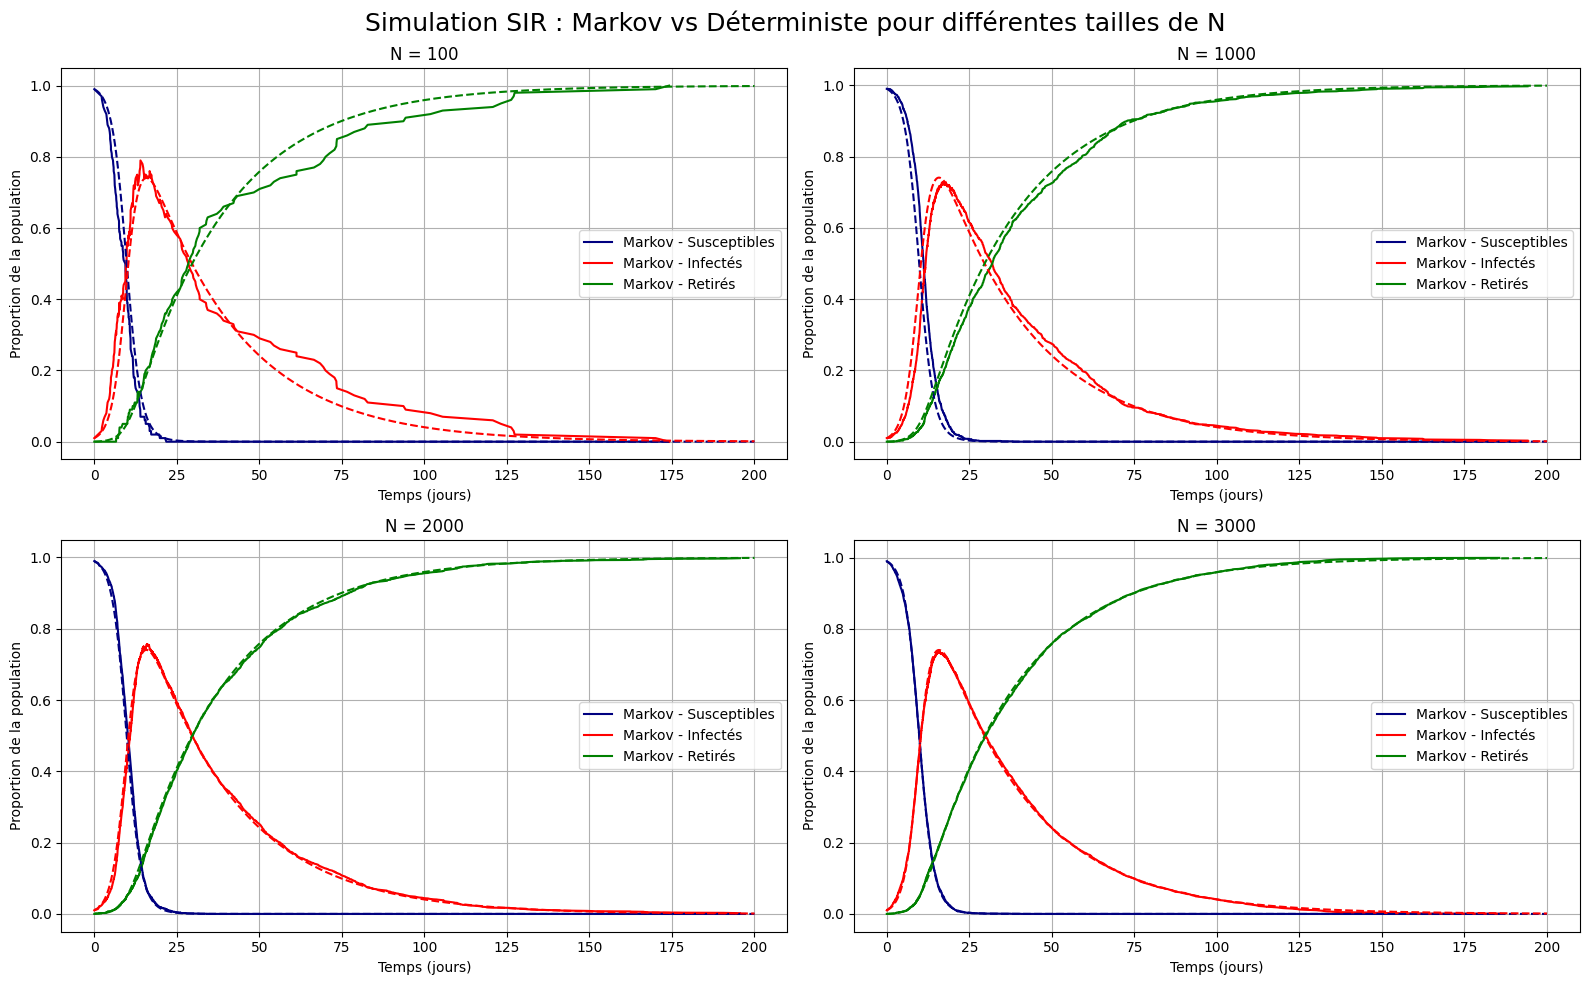

In [30]:
# paramètres du modèle SIR
gamma = 1 / 28          # On fixe le taux de récupération (1 guérison en 28 jours en moyenne)
beta = 0.5              # On fixe le taux d'infection

# Simulation pour différentes tailles de population
valeurs_de_N = [100, 1000, 2000, 3000]
duree = 200  # Durée de la simulation

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.ravel()

for idx, N in enumerate(valeurs_de_N):
    # Conditions initiales
    S0 = 0.99 * N  # On initialise 99% de la population comme susceptible
    I0 = 0.01 * N  # On initialise 1% de la population comme infectée
    R0 = 0         # On initialise 0% de la population comme retirée

    # Simulation Markov
    t_markov, S_markov, I_markov, R_markov = markov(I0, S0, R0, duree, gamma, beta)
    
    # on normalise les résultats
    S_markov = np.array(S_markov) / N  
    I_markov = np.array(I_markov) / N  
    R_markov = np.array(R_markov) / N  

    # Simulation déterministe avec solve_ivp
    sol_det = solve_ivp(
        fun=sir_model,              
        t_span=(0, duree),           # def de l'intervalle de temps
        y0=[I0 / N, S0 / N, R0 / N], # On donne les conditions initiales en proportion
        args=(gamma, beta),         
        t_eval=np.linspace(0, duree, 1000), # points où on veut les solutions
        method='RK45',               # méthode Runge-Kutta d'ordre 5
        max_step=0.01                # On impose un pas de temps maximum pour la précision
    )

    i_det, s_det, r_det = sol_det.y  # On récupère les courbes des infectés, susceptibles et retirés

    # Tracé des courbes
    axes[idx].plot(t_markov, S_markov, label="Markov - Susceptibles", color='navy')  
    axes[idx].plot(t_markov, I_markov, label="Markov - Infectés", color='red')       
    axes[idx].plot(t_markov, R_markov, label="Markov - Retirés", color='green')       

    axes[idx].plot(sol_det.t, s_det, '--', color='navy') 
    axes[idx].plot(sol_det.t, i_det, '--', color='red')    
    axes[idx].plot(sol_det.t, r_det, '--', color='green') 

    axes[idx].set_title(f"N = {N}")
    axes[idx].set_xlabel("Temps (jours)")
    axes[idx].set_ylabel("Proportion de la population")
    axes[idx].legend()
    axes[idx].grid(True)

plt.suptitle("Simulation SIR : Markov vs Déterministe pour différentes tailles de N", fontsize=18)
plt.tight_layout()
plt.show() 


Le modèle du processus de Markov converge vers le modèle déterministe à partir d'une population de 1000 personnes

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
6. Question ouverte
</div>

# Estimation des paramètres $\beta$ et $\gamma$ du modèle SIR à partir des données hospitalières COVID-19

Nous avons utilisé les données du département de Paris (75) entre mars et décembre 2020, issues de Santé Publique France.

Pour estimer les paramètres du modèle SIR :
- Le nombre d'infectés $I(t)$ est approximé par les hospitalisations et réanimations en cours.
- Le nombre de retirés $R(t)$ est obtenu par le cumul des retours à domicile et des décès.
- Les susceptibles $S(t)$ sont calculés par $S(t) = N - I(t) - R(t)$, où $N$ est la population totale.

Nous avons ensuite utilisé les formules suivantes :
- $\gamma(t) \approx \frac{r'(t)}{i(t)}$
- $\beta(t) \approx \frac{\Delta I(t) + \Delta R(t)}{S(t) \times I(t) / N}$


In [31]:
#Import de la base de données
df = pd.read_csv('donnees-covid.csv', sep=';')

In [32]:
df_75 = df.loc[(df['dep']=='75'),:]

In [33]:
df_75

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
19800,75,2020-03-19,167,41,11,31
19801,75,2020-03-20,120,21,5,28
19802,75,2020-03-21,138,34,7,35
19803,75,2020-03-22,147,31,4,33
19804,75,2020-03-23,189,31,18,33
...,...,...,...,...,...,...
20059,75,2020-12-03,31,6,10,48
20060,75,2020-12-04,46,15,7,49
20061,75,2020-12-05,16,1,3,40
20062,75,2020-12-06,16,3,2,6


In [34]:
def estimer_beta_gamma(fichier_csv, departement, population_departement):
    # On charge les données
    donnees = pd.read_csv(fichier_csv, sep=';')
    donnees_dep = donnees[donnees['dep'] == str(departement)].copy()
    donnees_dep['jour'] = pd.to_datetime(donnees_dep['jour'])
    donnees_dep = donnees_dep.sort_values('jour').reset_index(drop=True)

    # On calcule le stock d'infectés I(t)
    infectes = [0]
    for idx, ligne in donnees_dep.iterrows():
        nouvelles_infections = ligne['incid_hosp'] + ligne['incid_rea']  # nouvelles hospitalisations + réanimations
        nouvelles_sorties = ligne['incid_rad'] + ligne['incid_dc']        # nouveaux retours à domicile + décès
        infectes_actuel = infectes[-1] + nouvelles_infections - nouvelles_sorties  # évolution du stock
        infectes_actuel = max(infectes_actuel, 0)  # on évite un stock négatif
        infectes.append(infectes_actuel)
    donnees_dep['I'] = infectes[1:]  # on retire l'élément initial inutile

    # On calcule les retirés cumulés R(t)
    donnees_dep['R'] = donnees_dep['incid_rad'].cumsum() + donnees_dep['incid_dc'].cumsum()

    # On calcule les susceptibles S(t)
    donnees_dep['S'] = population_departement - donnees_dep['I'] - donnees_dep['R']

    # On calcule les variations journalières
    donnees_dep['dI'] = donnees_dep['I'].diff().fillna(0)
    donnees_dep['dR'] = donnees_dep['R'].diff().fillna(0)

    # On met tout en proportion par rapport à la population
    donnees_dep['s'] = donnees_dep['S'] / population_departement
    donnees_dep['i'] = donnees_dep['I'] / population_departement
    donnees_dep['r'] = donnees_dep['R'] / population_departement

    # On estime gamma et beta chaque jour
    donnees_dep['gamma'] = donnees_dep['dR'] / donnees_dep['I']
    donnees_dep['beta'] = (donnees_dep['dI'] + donnees_dep['dR']) / (donnees_dep['s'] * donnees_dep['i'] * population_departement)

    # On enlève les valeurs infinies ou manquantes
    donnees_dep = donnees_dep.replace([float('inf'), float('-inf')], pd.NA).dropna()

    # On calcule les moyennes finales
    gamma_moyen = donnees_dep['gamma'].mean()
    beta_moyen = donnees_dep['beta'].mean()

    return gamma_moyen, beta_moyen

# Utilisation de la fonction
chemin = "donnees-covid.csv"
population_paris = 2145000

gamma, beta = estimer_beta_gamma(chemin, '75', population_paris)
print(f"gamma = {gamma:.4f}, beta = {beta:.4f}")
print(f"R0 = {beta / gamma:.2f}")

gamma = 0.0149, beta = 0.0263
R0 = 1.77


Après calcul des valeurs, nous obtenons :

- $\gamma \approx 0.0149$ par jour  
  Cela nous paraît long par rapport à ce que nous attendions (14–20 jours en moyenne alors que là, cela donne 67 jours). Cela peut être lié au fait que nous utilisons des données d'hospitalisation, où les durées de séjour sont souvent longues en cas de Covid sévère début 2020. Mais il faut aussi noter que les approximations faites dans notre méthode peuvent expliquer cet écart. (voir plus bas)

- $\beta \approx 0.0263$ par jour

- $R_0 = \frac{\beta}{\gamma} \approx 1.77$

Le $R_0$ trouvé est plus faible que ce que nous attendions (environ 3 comme discuté en cours), ce qui peut s'expliquer par le fait que des restrictions (gestes barrières, fermetures progressives des écoles et commerces) avaient déjà commencé à être mises en place en France à partir du début du mois de mars 2020, avant même le confinement strict du 17 mars.

Concernant les approximations qui peuvent influencer nos résultats :
- Nous avons supposé que $I(t)$ (le nombre d'infectés) correspond directement au stock d'hospitalisations + réanimations, alors que beaucoup de cas de Covid-19 n'ont pas été hospitalisés (cas légers ou asymptomatiques). Cela sous-estime donc le nombre réel d'infectés.
- Le modèle SIR suppose que l'infection dure un temps exponentiel moyen constant alors que dans la réalité la durée de séjour à l'hôpital varie beaucoup d'un patient à l'autre.
- Les données utilisées sont des agrégats journaliers, mais il peut y avoir des retards ou des variations liées aux délais de traitement (enregistrement de l'infecté par exemple...).

<div style="
    background-color:rgb(60, 2, 185);
    padding: 15px 20px;
    border-radius: 8px;
    border-left: 5px solid #1890ff;
    margin: 15px 0;
    font-size: 2.5em;
    box-shadow: 0 2px 4px rgba(0,0,0,0.1);
">
Fin
</div>